In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
class HeightEstimation(nn.Module):
  def __init__(self,inp_dim):
    super().__init__()
    self.model=nn.Sequential(
        nn.Linear(inp_dim,256),
        nn.ReLU(),
        nn.Linear(256,128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,1)

    )
  def forward(self,x):
    return self.model(x)+1.0

In [ ]:
def datasetgeneration(n,k,m,no_of_samples=1000):
  x=[]
  y=[]

  for _ in range(no_of_samples):
    P=np.random.uniform(-100,100,size=(k,n-k))
    P_flat=P.flatten()

    inp_features=np.concatenate(([n,k,m],P_flat))
    hm_value=np.random.uniform(1,20)

    x.append(inp_features)
    y.append(hm_value)

  return np.array(x),np.array(y)

In [ ]:
def trainmodel(n, k, m, epochs=30):
    x, y = datasetgeneration(n, k, m, no_of_samples=2000)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

    # Convert to tensors and ensure proper shapes [N,1]
    train_x = torch.tensor(x_train, dtype=torch.float32)
    test_x = torch.tensor(x_test, dtype=torch.float32)
    train_y = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # [N,1]
    test_y = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)    # [N,1]

    # Create DataLoaders
    train_loader = DataLoader(list(zip(train_x, train_y)), batch_size=32, shuffle=True)
    test_loader = DataLoader(list(zip(test_x, test_y)), batch_size=32)

    input_dim = x.shape[1]
    model = HeightEstimation(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x, y in train_loader:
            optimizer.zero_grad()

            pred = model(x)
            pred = torch.clamp(pred, min=1e-6)  # Prevent ≤ 0
            loss = criterion(torch.log2(pred), torch.log2(y))

            loss.backward()  # Fixed: added ()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()
    return model, test_loader

In [ ]:
def evaluate_model(model,test_loader):
  model.eval()
  y_preds=[]
  y_true=[]

  with torch.no_grad():
    for x,y in test_loader:
      pred=model(x)
      y_preds.append(pred.numpy())
      y_true.append(y.numpy())

  y_preds=np.vstack(y_preds)
  y_true=np.vstack(y_true)

  cost=np.mean((np.log2(y_true)-np.log2(y_preds))**2)
  print(f"Cost:={cost:.6f}")
  return y_preds,y_true


Epoch 1/30, Loss: 4.8532
Epoch 2/30, Loss: 1.0827
Epoch 3/30, Loss: 1.0370
Epoch 4/30, Loss: 1.0003
Epoch 5/30, Loss: 0.9659
Epoch 6/30, Loss: 0.9240
Epoch 7/30, Loss: 0.8575
Epoch 8/30, Loss: 0.8075
Epoch 9/30, Loss: 0.7362
Epoch 10/30, Loss: 0.6363
Epoch 11/30, Loss: 0.6138
Epoch 12/30, Loss: 0.6345
Epoch 13/30, Loss: 0.6630
Epoch 14/30, Loss: 0.8569
Epoch 15/30, Loss: 0.5262
Epoch 16/30, Loss: 0.8781
Epoch 17/30, Loss: 0.5761
Epoch 18/30, Loss: 0.4168
Epoch 19/30, Loss: 0.6602
Epoch 20/30, Loss: 0.7923
Epoch 21/30, Loss: 0.3844
Epoch 22/30, Loss: 0.7962
Epoch 23/30, Loss: 0.4200
Epoch 24/30, Loss: 0.3787
Epoch 25/30, Loss: 0.5057
Epoch 26/30, Loss: 0.3288
Epoch 27/30, Loss: 0.2464
Epoch 28/30, Loss: 0.4577
Epoch 29/30, Loss: 0.2639
Epoch 30/30, Loss: 0.4660


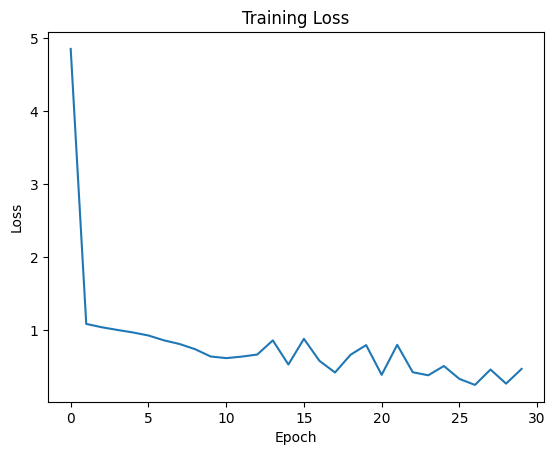

In [ ]:
model, test_loader = trainmodel(n=9, k=4, m=2)